# Predicting SalePrice

## Objectives

Create and evaluate model to predict SalePrice of building

## Inputs:
* outputs/datasets/cleaned/test.parquet.gzip
* outputs/datasets/cleaned/train.parquet.gzip
* Conclusions from Feature Engineering jupyter_notebooks/04_Feature_Engineering.ipynb

## Outputs
* Train Set: Features and Target
* Test Set: Features and Target
* Feature Engineering Pipeline
* Modeling Pipeline
* Features Importance Plot

## Change working directory
In This section we will get location of current directory and move one step up, to parent folder, so App will be accessing project folder.

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os

from feature_engine.transformation import BoxCoxTransformer

current_dir = os.getcwd()
current_dir

'/Users/pecukevicius/DataspellProjects/heritage_houses_p5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("you have set a new current directory")

you have set a new current directory


Confirm new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/Users/pecukevicius/DataspellProjects/heritage_houses_p5'

## Loading Dataset

In [4]:
import pandas as pd

df_train = pd.read_parquet('outputs/datasets/cleaned/train.parquet.gzip')
df_train.head()
import pandas as pd

df_test = pd.read_parquet('outputs/datasets/cleaned/test.parquet.gzip')
df_train.head()

,Unnamed: 0,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,...,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice,Consistency
809,809,1075,1063,2,No,0,Unf,849,0,360,...,0,156,5,5,849,0,1898,1965,106000,True
608,608,1940,1254,4,Mn,428,BLQ,537,0,380,...,0,0,6,8,965,0,1934,1998,359100,True
1189,1189,1028,776,3,No,0,Unf,994,0,442,...,0,60,5,7,994,0,1999,1999,189000,True
1039,1039,630,0,1,Av,509,GLQ,121,0,286,...,0,0,4,4,630,0,1970,1970,80000,True
1297,1297,1072,0,2,Gd,547,GLQ,0,0,525,...,82,44,5,6,547,0,2005,2006,140000,True


## Data Exploration
Before exploring data and doing transformations, as we decided earlier, we will select these features:

In [5]:
# importing home-made functions
from extra_funcionality import load_data

# getting list of selected features
hypothesis_1_features = load_data('hypothesis_1_features')
hypothesis_1_features

['BsmtFinType1',
 'KitchenQual',
 'OverallQual',
 'BsmtExposure',
 'GrLivArea',
 'GarageFinish',
 '1stFlrSF',
 'TotalBsmtSF',
 'GarageArea',
 'YearBuilt',
 'SalePrice']

In [6]:
# In dataframe keeping just selected features
df_train = df_train[hypothesis_1_features]
df_test = df_test[hypothesis_1_features]

## Machine Learning

In [7]:
### Data Cleaning
from sklearn.pipeline import Pipeline

### Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine import transformation as vt

### Feat Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

# Custom Transformer for dividing 'YearBuilt' by 1e69
from sklearn.base import BaseEstimator, TransformerMixin


class DivideByConstant(BaseEstimator, TransformerMixin):
    def __init__(self, constant=1e69):
        self.constant = constant

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['YearBuilt'] = X['YearBuilt'] / self.constant
        return X


def PipelineClf(model):
    pipeline_base = Pipeline([
        # Feature Engineering
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish',
                                                                'KitchenQual'])),
        ('BoxCoxTransformer', BoxCoxTransformer(variables=['GrLivArea', 'YearBuilt'])),
        # Divide 'YearBuilt' by 1e69
        ('DivideByConstant', DivideByConstant(constant=1e69)),
        ('YeoJohnsonTransformer', vt.YeoJohnsonTransformer(variables=['1stFlrSF', 'TotalBsmtSF'])),

        ("feat_selection", SelectFromModel(model)),

        ("model", model),
    ])

    return pipeline_base

## ML Pipeline for Modeling and Hyperparameters Optimization

This is custom Class Hyperparameter Optimization

In [8]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

### Splitting Sets to Features and targets

In [9]:
# Identify the target variable column name
target_column = 'SalePrice'

# Extract the target variable
y_train = df_train[target_column]
y_test = df_test[target_column]

# Remove the target variable from the DataFrame to create the feature DataFrame
X_train = df_train.drop(columns=[target_column])
X_test = df_test.drop(columns=[target_column])


### Grid Search CV

For this time being we will use default hyperparameters, just to select best algorithms

In [10]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

### Running Grid Search CV

### Results Inspection

In [11]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [12]:
import numpy as np
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.679283,0.796797,0.841347,0.060215
4,AdaBoostRegressor,0.681432,0.783349,0.8235,0.051576
3,ExtraTreesRegressor,0.695694,0.775511,0.841125,0.055445
2,RandomForestRegressor,0.677178,0.752818,0.788361,0.043303
6,XGBRegressor,0.555616,0.70232,0.794635,0.083383
1,DecisionTreeRegressor,0.607484,0.661867,0.734878,0.051121
0,LinearRegression,0.408204,0.651657,0.763657,0.128741


We can see that GradientBoostingRegressor shows most promising results, mean = 0.841347
Now we will add extra HyperParameters

In [13]:
models_tuning_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),

}
param_grid = {
    "GradientBoostingRegressor": {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [3, 5],
        'model__min_samples_split': [2],
        'model__min_samples_leaf': [1]
    }
}

In [14]:
search = HyperparameterOptimizationSearch(models=models_tuning_search, params=param_grid)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [15]:

grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,GradientBoostingRegressor,0.689389,0.805486,0.852885,0.059671,0.05,3,1,2,100
1,GradientBoostingRegressor,0.677339,0.798196,0.848134,0.062108,0.05,3,1,2,200
4,GradientBoostingRegressor,0.679283,0.796797,0.841347,0.060215,0.1,3,1,2,100
2,GradientBoostingRegressor,0.675488,0.792802,0.833527,0.059941,0.05,5,1,2,100
3,GradientBoostingRegressor,0.665361,0.783537,0.824261,0.060257,0.05,5,1,2,200
5,GradientBoostingRegressor,0.661665,0.782831,0.826369,0.061803,0.1,3,1,2,200
6,GradientBoostingRegressor,0.663849,0.781707,0.830985,0.060251,0.1,5,1,2,100
7,GradientBoostingRegressor,0.655539,0.766537,0.812032,0.057276,0.1,5,1,2,200


Yay, we managed to increase mean from 0.841347 to 0.852885. not a lot but still something.

Selecting best model

In [16]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

Parameters for best model

In [17]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.05,
 'model__max_depth': 3,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

In [18]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('BoxCoxTransformer',
                 BoxCoxTransformer(variables=['GrLivArea', 'YearBuilt'])),
                ('DivideByConstant', DivideByConstant()),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['1stFlrSF', 'TotalBsmtSF'])),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingRegressor(random_state=0))),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.05,
                                           random_state=0))])

## Accessing Feature Importance

* These are the 2 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea']


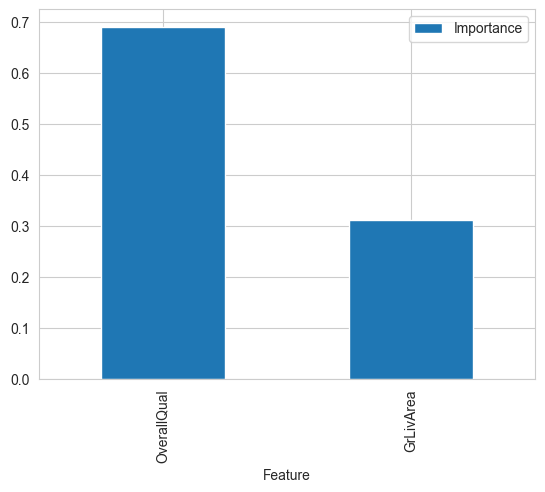

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feat engine, the feature may space changes
data_cleaning_feat_eng_steps = 4 # how many data cleaning and feature engineering the pipeline has
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
                         .sort_values(by='Importance', ascending=False)
                         )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

## Evaluating Model on Train and Test Sets

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error

def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)

def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print("\n")

def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    # Train plot
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0], color='blue')
    axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')  # Red line y=x
    axes[0].set_xlabel("Actual Values")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set Performance")

    # Test plot
    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1], color='green')
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Red line y=x
    axes[1].set_xlabel("Actual Values")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set Performance")

    plt.show()


Model Evaluation 

* Train Set
R2 Score: 0.853
Mean Absolute Error: 22392.626


* Test Set
R2 Score: 0.448
Mean Absolute Error: 31091.712




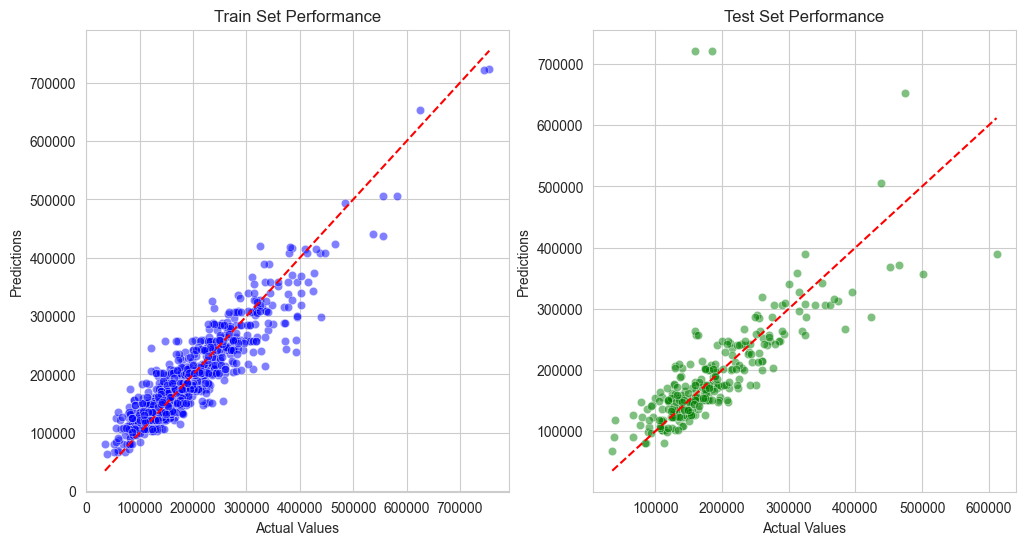

In [21]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

## This model is not accurate enough, as mean score of test is just 0.448

## Hypothesis 2: we need all features to predict Sale Price